In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Differentiable Agent-Based Models

In previous notebooks we learned how automatic differentiation (AD) can be used to obtain gradients from stochastic computer programs. Next, we will use what we have learned to implement several differentiable programs, including a differentiable agent-based model (ABM).

<!-- We are now in a good spot to code our first differentiable ABM. Refer to notebooks 1 and 2 for a review of automatic differentiation (AD). -->

## The Random Walk

To begin let's implement a one-dimensonal random walk. Recall that a one-dimensional random walk is given by the following recursion:

$$
x_{t+1} = x_t + \begin{cases}1 &\mathrm{if} &\xi = 1 \\ -1 &\mathrm{if} &\xi = 0\end{cases}, \quad \xi \sim \mathrm{Bern}({\theta})
$$

where  $\text{Bern}$ denotes the Bernoulli distribution, $x_{t}$ denotes the position observed after $t$ steps, and $\theta$ denotes a parameter determining the probability of moving in the positive direction. Let's use PyTorch to implement this model as a stochastic program called `random_walk`.

In [2]:
def random_walk(theta, n_timesteps):
    x = torch.tensor([0.])
    for i in range(n_timesteps-1):
        xi = torch.distributions.Bernoulli(theta).sample()
        if xi == 1:
            next_x = x[-1] + 1
        else:
            next_x = x[-1] - 1
        x = torch.hstack((x, next_x))
    return x

Let's forward simulate our stochastic program to make sure everything is working correclty!

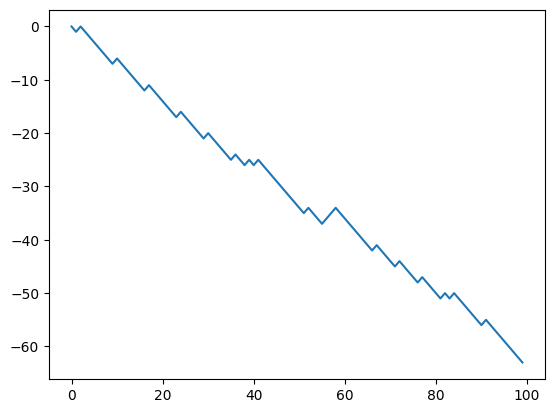

In [3]:
theta = 0.2
n_timesteps = 100
x = random_walk(theta, n_timesteps)
plt.plot(x)

Now that we are confident the model is correclty implemented, let's check whether PyTorch can compute a gradient.  Since `random_walk` returns a time series and has one parameter the Jacobian,

$$
(J)_t = \frac{\partial {x_t}}{\partial \theta},
$$

will be a row vector. Let's plot the Jacobian at $\theta = 0.2$ by using the `torch.autograd` module.

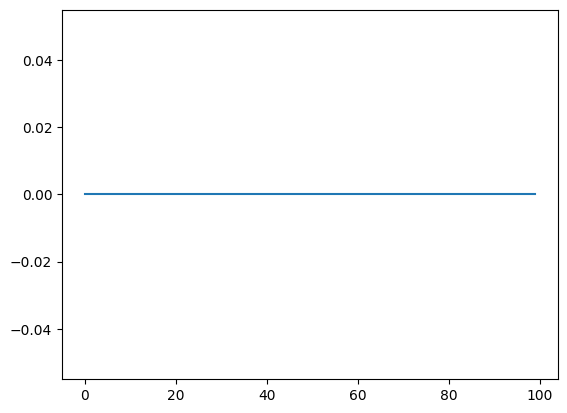

In [4]:
dx_dtheta = torch.autograd.functional.jacobian(
    lambda x: random_walk(theta=x, n_timesteps=n_timesteps), torch.tensor(theta)
)
plt.plot(dx_dtheta)

We immediately see that all entries of the Jacobian are zero! This is happening for two reasons. Firstly, as we saw in the previous notebook, the Bernoulli distribution is not differentiable by default and we need to a use technique like the Gumbel-Softmax trick to differentiate through it. We can implement the Gumbel-Sofxmax trick in ``random walk`` by replacing

```python
 xi = torch.distributions.Bernoulli(theta).sample()
``` 

with 

```python
logits = torch.hstack((theta, 1 - theta)).log()
xi = torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=True)[0]
```

There is also an issue with control flow. Under the hood, PyTorch builds a **static computational graph**. This means that the structure of the computational graph cannot change at run-time based on the outcome of control flow statements. As a result, the gradient will not correctly flow backwards through `if` statements that depend on the parameters we want to differentiate with respect to. Analysing the code of `random_walk` we find the following control flow statement:

```python
xi = torch.distributions.Bernoulli(theta).sample()
if xi == 1:
    next_x = x[-1] + 1
else:
    next_x = x[-1] - 1
```

Since the `if` statement predicate depends on `xi` which in turn depends on `theta`, the gradient will not flow backwards properly. To fix this issue, we can reimplement the `if` statement using  **masking**.

```python
xi = torch.distributions.Bernoulli(theta)
next_x = xi * (x[-1] + 1) + (1-xi) * (x[-1] - 1)
```

Note that if `xi = 1` then `next_x` will be equal to `x[-1] +1` as `(1-xi)` will be equal to zero. That is, the `else` output of the original `if` statement is *masked out*. Likewise, if `xi = 0` then `next_x` will be equal to `x[-1] - 1` as the output `(x[-1] + 1)` is masked out by its multiplier `xi`. In other words, the code above is completely equivalent to the previous `if` statement. Moreover this code will play nicely with the static compuational graph generated by PyTorch as it contains no control flow statements.

Let's rewrite `random_walk` to implement both masking and the Gumbel-Softmax trick!

<!-- We obtain a gradient of 0. Why is that? There are two reasons:

1. As we noted in the previous tutorials, the Bernoulli distribution is not automatically differentiable, and we need to use a continuous relaxation such as Gumbel-Softmax.
2. AD frameworks such as PyTorch require a static computation graph to perform AD. Even though they support control flow statement such as `if` or `else`, they do not support control flow statements that depend on the parameters that we want to differentiate to. This can be circumvented by using masks. That is, a statement

```python
xi = torch.distributions.Bernoulli(theta)
if x:
    return a
else:
    return b
```

can be written as

```python
xi = torch.distributions.Bernoulli(theta)
y = xi * a + (1-xi) * b
```

with this in mind, we can rewrite our example as: -->


In [5]:
def random_walk(theta, n_timesteps, tau=0.1):
    x = torch.tensor([0.0])
    for i in range(n_timesteps - 1):
        logits = torch.hstack((theta, 1 - theta)).log()
        xi = torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=True)[0]
        next_x = x[-1] + 2 * xi - 1
        x = torch.hstack((x, next_x))
    return x

Let's run a simulation to check our model runs properly.

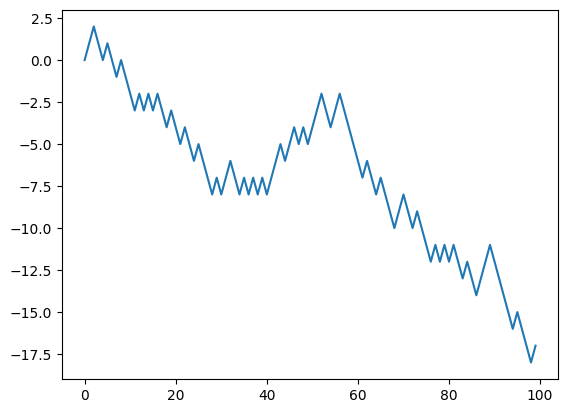

In [6]:
theta = torch.tensor(0.4)
n_timesteps = 100
x = random_walk(theta, n_timesteps)
plt.plot(x)

Both implementations of `random_walk` behave identically. Any difference observed between simulation outputs is caused by the randomness of the Bernoulli distribution. This is because we set `hard=True` when employing the Gumbel-Softmax trick, ensuring that the Bernoulli distribution is only replaced by a continuous relaxation when applying the chain rule during the backwards pass. If the previous sentence is confusing, you should review the previous notebook. Let's check the Jacobian again!

<!-- Now, remember, because of the `hard=True` the forward simulation is identical to the previous case. That is, the continuous relaxation that we model with Gumbel-Softmax only affects the backward gradient propagation. Let us now recompute the jacobian: -->

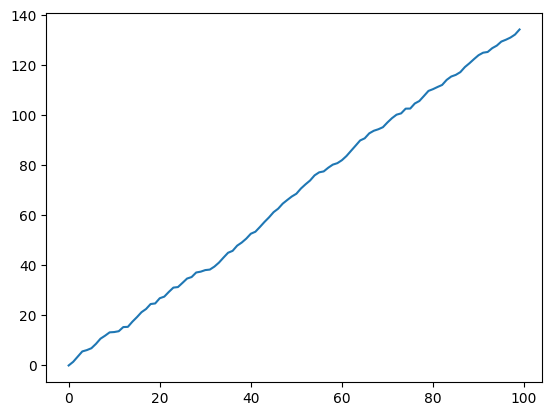

In [7]:
dx_dtheta = torch.autograd.functional.jacobian(
    lambda x: random_walk(theta=x, n_timesteps=n_timesteps, tau=1.0), theta
)
plt.plot(dx_dtheta)

PyTorch is now properly estmating the Jacobian thanks to our changes. Recall that the bias-variance trade-off of the Gumbel-Softmax trick is controlled implicitly by setting the temperatrue $\tau$. Let's investigate this trade-off in the context of the random walk. Thankfully, the exact analytical gradient is easy to derive for the random walk:

$$
\begin{align}
\frac{\partial}{\partial \theta} \mathbb E[x_t]  & = \frac{\partial}{\partial \theta} \mathbb E\left[ \sum_{j=1}^{t} 2 \mathrm{Bern(\theta)} - 1 \right]\\
                                                 & = \frac{\partial}{\partial \theta} (2  t  \theta - t) \\
                                                 & = 2t
\end{align}
$$

This means we can compare the gradients output by PyTorch against the analytical gradient for different temperature settings!

<!-- The temperature parameter of the GS distribution entails a bias-variance tradeoff as explained in the previous notebook. Let's analyze the effect here.  -->

In [8]:
taus = [0.1, 0.5, 1.0]
n_gradient_samples = 50
n_timesteps = 50
gradients_per_tau = {tau: [] for tau in taus}
for tau in taus:
    for i in range(n_gradient_samples):
        dx_dtheta = torch.autograd.functional.jacobian(
            lambda x: random_walk(theta=x, n_timesteps=n_timesteps, tau=tau),
            theta,
            vectorize=True,
        )
        gradients_per_tau[tau].append(dx_dtheta)

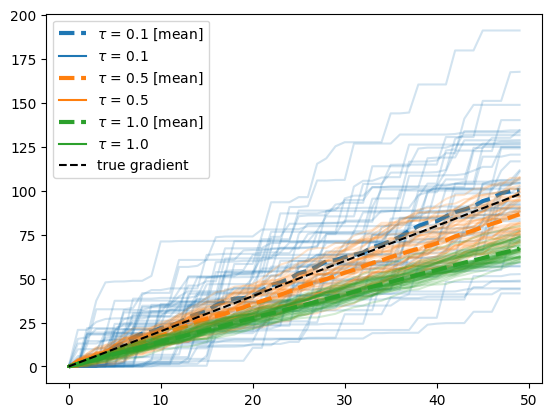

In [12]:
fig, ax = plt.subplots()
for i, tau in enumerate(gradients_per_tau):
    for grad in gradients_per_tau[tau]:
        ax.plot(grad, color=f"C{i}", alpha=0.2)
    ax.plot(
        sum(gradients_per_tau[tau]) / n_gradient_samples,
        color=f"C{i}",
        linestyle="--",
        label=rf"$\tau$ = {tau} [mean]",
        lw=3
    )
    ax.plot([], [], color=f"C{i}", label=rf"$\tau$ = {tau}")
ax.plot(
    range(n_timesteps),
    2 * np.array(range(n_timesteps)),
    color="black",
    linestyle="--",
    label="true gradient",
)
ax.legend()

<!-- First let's address how we obtained the true gradient value by the black dashed line $y=x$. Since the random walk is a linear model, we can write

$$
\begin{align}
\frac{\partial}{\partial \theta} \mathbb E[x_N]  & = \frac{\partial}{\partial \theta} \mathbb E\left[ \sum_{j=1}^{N} 2 \mathrm{Bernoulli(\theta)} - 1 \right]\\
                                                 & = \frac{\partial}{\partial \theta} (2  N  \theta - N) \\
                                                 & = 2 N
\end{align}
$$ -->

Unsurprisingly, as $\tau$ decreases, the mean of each gradient estimate gets closer to the analytical gradient, whilst the variance increases significantly. In this case, it may be more reasonable to use $\tau=0.5$ rather than $\tau=0.1$, since a small increase in bias is compensated by a large reduction in variance.


 <!-- but the variance increases significantly. In this particular case, we may do better with $\tau=0.5$ than $\tau=0.1$ since the small bias is an acceptable trade for a big reduction in variance. -->

## The SIR model

Next, we will implement a simple epidemilogical ABM modelling the spread of a disease through a population. This ABM is compromised of $N$ agents who may occupy one of three states: susceptible, infected, or recovered. As a result, we will call it the **SIR ABM**. On each time step $t$, the probability of a susceptible agent becoming infected is given by

$$
1 - \exp{\left(-\beta I \Delta t\right)},
$$

where $\Delta t$ is the length of the time step, $\beta$ is effective contact rate (higher values correspond to faster disease spread), and $I$ is the fraction of individuals infected at time $t$. Likewise, the probability that an infected individual recovers is given by 

$$
1 - \exp{\left(-\gamma \Delta t\right)},
$$

where $\gamma$ is the recovery rate (higher values mean agents recover faster). Whilst this ABM is simple, it forms the basis for many complicated epidemilogical models. For instance it is easy to see how this model may be extended to one in which agents follow a daily schedule and only come into contact with agents occupying the same geospatial area as them on each time step. Likewise one can extend this model by adding demographic properties to each agent which affect their probability of infection.

We can implement the SIR ABM using masking and the Gumbel-Softax trick, just as we did for the random walk!

<!-- Let us know code a differentiable Susceptible-Infected-Recovered epidemiological model. The ABM is a discretization of the system of equations -->

<!-- $$
\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= - \beta SI \\
\frac{\mathrm{d} I}{\mathrm{d} t} &=  \beta SI - \gamma I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I \\
\end{align}

$$

where $\beta$ is the effective contact rate (higher values correspond to faster disease spread), and $\gamma$ is the recovery rate (e.g., a $\gamma =0.05$ corresponds to a mean recovery time of 20 days), and S, I, R are the fraction of susceptible, infected, and recovered individuals respectively.

The corresponding ABM can be obtained by considering a collection of $N$ agents. At each time-step, the probability of agent $i$ getting infected is given by

$$
p_i = 1 - \exp{\left(-\beta I \Delta t\right)},
$$

where $I$ is the fraction of individuals infected at this time, and $\Delta t$ is the duration of the time-step. Likewise, an infected individual can recover with probability

$$
q_i = 1 - \exp{\left(-\gamma \Delta t\right)}.
$$ -->

In [13]:
def sample_bernoulli(p, tau):
    logits = torch.vstack([p, 1 - p]).t().log()
    return torch.nn.functional.gumbel_softmax(logits=logits, tau=tau, hard=True)[:, 0]


def sir(
    beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t, tau=0.5
):
    # here S, I, R denote arrays of size (n_agents, ) with 1 or 0 depending on their state.
    I = sample_bernoulli(initial_fraction_infected * torch.ones(n_agents), tau)
    S = 1.0 - I
    R = torch.zeros(n_agents)
    infections_per_timestep = torch.tensor([])
    recoveries_per_timestep = torch.tensor([])
    for _ in range(n_timesteps):
        # sample probs
        probs_infected = S * (1.0 - torch.exp(-beta * sum(I) / n_agents * delta_t))
        probs_infected = torch.clip(probs_infected, 1e-8, 1.0)
        is_infected = sample_bernoulli(probs_infected, tau)
        probs_recovery = I * (1.0 - torch.exp(-gamma * delta_t))
        probs_recovery = torch.clip(probs_recovery, 1e-8, 1.0)
        is_recovered = sample_bernoulli(probs_recovery, tau)
        # update
        S = S - is_infected
        I = I + is_infected - is_recovered
        R = R + is_recovered
        # save
        infections_per_timestep = torch.hstack(
            (infections_per_timestep, is_infected.sum() / n_agents)
        )
        recoveries_per_timestep = torch.hstack(
            (recoveries_per_timestep, is_recovered.sum() / n_agents)
        )
    return infections_per_timestep, recoveries_per_timestep

Note that ``sir`` outputs a time series tracking the fraction of infected and recovered individuals through time. The parameters of the model are $\beta$ and $\gamma$. Let's run our stochastic program and plot the output!

In [14]:
beta = torch.tensor(0.2)
gamma = torch.tensor(0.05)
initial_fraction_infected = 0.01
n_agents = 10000
n_timesteps = 60
delta_t = 1

inf_t, rec_t = sir(beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t)

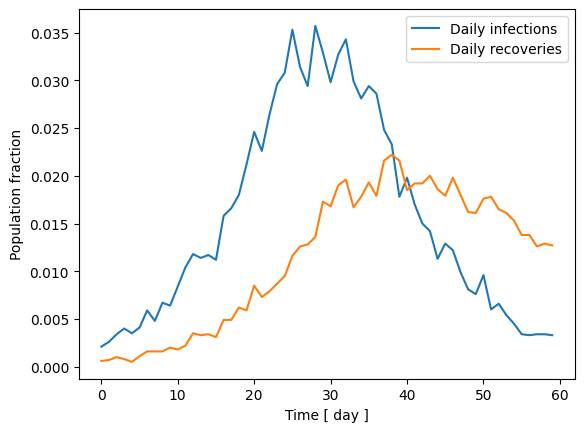

In [15]:
fig, ax = plt.subplots()
ax.plot(inf_t, label = "Daily infections")
ax.plot(rec_t, label = "Daily recoveries")
ax.set_xlabel("Time [ day ]")
ax.set_ylabel("Population fraction")
ax.legend()

Just as we did for the random walk model, we can check gradients using the ``torch.autograd`` module. Let's evaluate the gradient of each output with respect to $\gamma$ and $\beta$.

In [16]:
# fixed parameters
initial_fraction_infected = 0.01
n_agents = 1_000
delta_t = 1
n_timesteps = 60
def faux(x):
    beta, gamma = x
    return sir(beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t)

beta = 0.2
gamma = 0.05
jacobian = torch.autograd.functional.jacobian(faux, torch.tensor([beta, gamma]), vectorize=True)

Text(0, 0.5, 'Gradient')

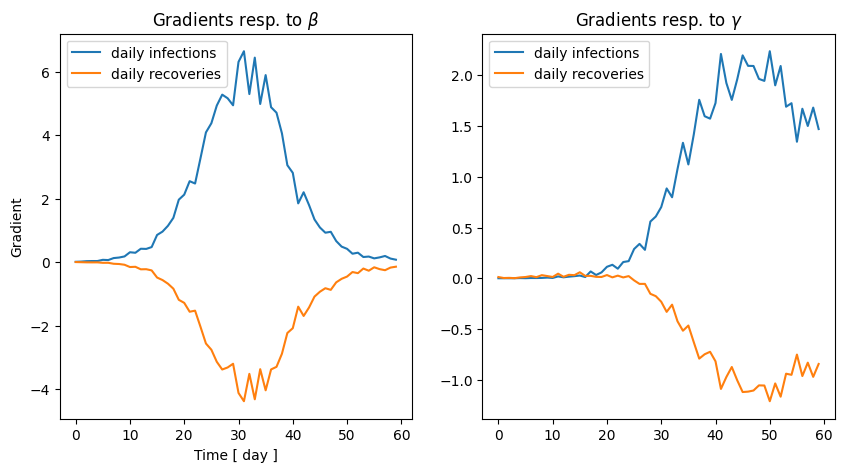

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(jacobian[0][:,0], label = "daily infections")
ax[0].plot(jacobian[0][:,1], label = "daily recoveries")
ax[0].set_title(r"Gradients resp. to $\beta$")
ax[0].legend()
ax[1].plot(jacobian[1][:,0], label = "daily infections")
ax[1].plot(jacobian[1][:,1], label = "daily recoveries")
ax[1].set_title(r"Gradients resp. to $\gamma $")
ax[1].legend()
ax[0].set_xlabel("Time [ day ]")
ax[0].set_ylabel("Gradient")

## Point Calibration with Gradient Descent

Now that we have a differentiable version of the SIR ABM we can try to calibrate it. Calibration refers to the process of fine-tuning ABM parameters in order to reproduce the behaviour of a real-world complex system.

Assume that we have observed a multivariate time-series $\mathbf{y}$ tracking the fraction of infected and recovered individuals in a real world population. We would like to calibrate the contact rate $\beta$ and recovery rate $\gamma$ so that our ABM can reliably reproduce this data.

With this goal in mind, let $\text{SIR}(\beta, \gamma)$ denote the random output of the SIR ABM with parameters $(\beta, \gamma)$. Additionally, let $\ell(\cdot, \cdot)$ denote a loss function that captures the difference between the output of our ABM and the real world data $\mathbf{y}$. Throughout this notebook we will use the L2 loss. We can then select appropriate values for $\beta$ and $\gamma$ by minimising the following objective:

$$
(\beta^*, \gamma^*) = \arg\min_{\beta, \gamma} \mathbb{E}[\ell \left(\text{SIR}(\beta, \gamma), \mathbf y\right)]
$$

Since `sir` is differentiable, we can solve this optimisation problem via gradient descent! To illustrate this, let's first generate some synthetic data by simulating from the ABM with parameters $\beta=0.2$ and $\gamma=0.05$.

<!-- It's about time to do what we set up to do with this tutorial: using the gradients to calibrate our model. -->

<!-- Let's assume we have an observed (multivariate) time-series $\mathbf y$. We want to compute the "optimal" values of $\beta$ and $\gamma$ that generate $\mathbf x$ that is as close as possible as $\mathbf y$. More specifically, we want to compute

$$
(\beta^*, \gamma^*) = \argmin_{(\beta, \gamma)} \ell \, \left(\mathbf x(\beta, \gamma), \mathbf y\right)
$$

where $\ell$ is an appropritate distance function. In this case, we will just consider the standard L2 loss. -->

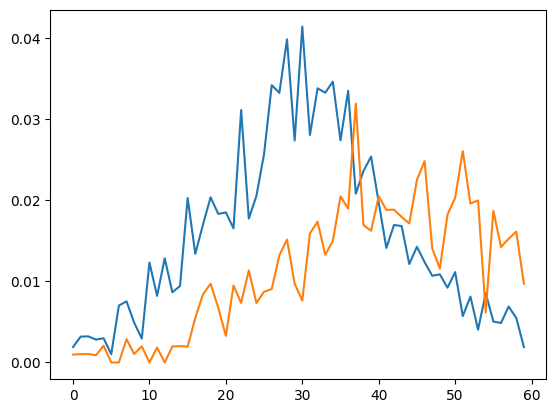

In [18]:
# let's generate some fake observation data first
true_beta = torch.tensor(0.2)
true_gamma = torch.tensor(0.05)
true_inf, true_rec = sir(
    true_beta, true_gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t
)
# let's add some observation noise
sigma_obs = 0.05
true_inf = true_inf + torch.randn(n_timesteps) * sigma_obs * true_inf
true_rec = true_rec + torch.randn(n_timesteps) * sigma_obs * true_rec

f, ax = plt.subplots(1, 1)
ax.plot(true_inf, label = "daily infections")
ax.plot(true_rec, label = "daily recoveries")


Now that we have generated some data let's try to recover the original parameters using gradient descent! The code which follows will look very familiar to PyTorch users who have trained neural networks, but there are a few subtle details that are worth highlighting.

Firstly, instead of optimising each parameter directly, we optimise their logarithmic values. This is to ensure that $\beta$ and $\gamma$ are always positive. Secondly, note that evaluating the gradients of $\beta$ and $\gamma$ requires backpropoagating through every time step via the chain rule. In other words, we are **backpropagating through time**. As result, in a similar sense to recurrent neural networks, we can suffer from exploding and vanishing gradients. In practice, we find that **clipping the gradient** can help mitigate exploding and vanishing gradients. PyTorch has a built-in function to clip gradients called  ``torch.clip_grad_norm`` which we employ in the code below.

With those details covered, let's perform gradient descent with the Adam optimiser!

In [19]:
log_beta = torch.tensor(0.0, requires_grad=True)
log_gamma = torch.tensor(0.0, requires_grad=True)
def loss(log_beta, log_gamma, obs_inf, obs_rec):
    beta = 10 ** log_beta
    gamma = 10 ** log_gamma
    inf, rec = sir(beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t)
    return torch.sum((inf - obs_inf) ** 2 + (rec - obs_rec) ** 2)

from tqdm import tqdm

n_epochs = 200
loss_hist = []
beta_hist = []
gamma_hist = []
optimizer  = torch.optim.Adam([log_beta, log_gamma], lr=0.05)
for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    l = loss(log_beta, log_gamma, true_inf, true_rec)
    l.backward()
    # clip norm this is important to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_([log_beta, log_gamma], 1)
    optimizer.step()
    loss_hist.append(l.item())
    beta_hist.append(10 ** log_beta.item())
    gamma_hist.append(10 ** log_gamma.item())

100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


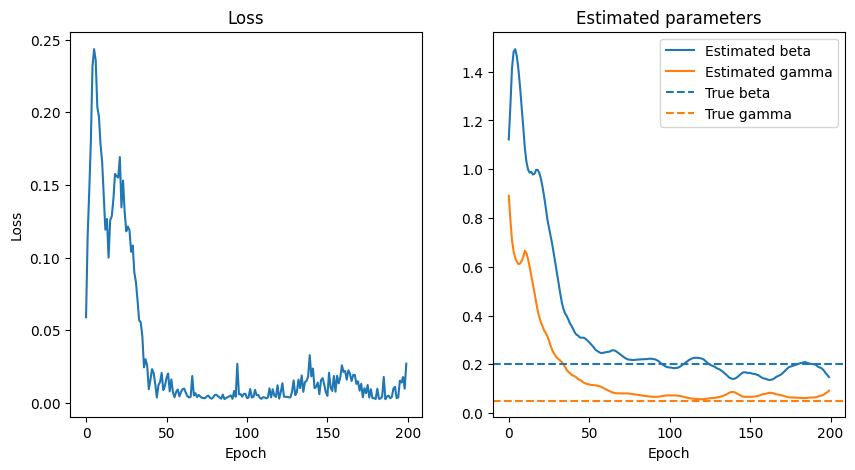

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(loss_hist)
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_title("Estimated parameters")
ax[1].plot(beta_hist, label = "Estimated beta", color = "C0")
ax[1].plot(gamma_hist, label = "Estimated gamma", color = "C1")
ax[1].axhline(true_beta, color="C0", linestyle="--", label="True beta")
ax[1].axhline(true_gamma, color="C1", linestyle="--", label="True gamma")
ax[1].set_xlabel("Epoch")
ax[1].legend()


We see that we can quickly recover the correct parameters in under 200 simulations! This would not be possible without a differentiable simulator, as we would be unable to evaluate gradients.

## Summary

In this notebook we showed how masking and the Gumbel-Softmax trick can be employed to build differentiable ABMs. Moreover we illustrated how gradient descent can be used to calibrate differentiable ABMs. Note that our calibration procedure returned only one set of values. Such procedures are known as point calibration methods, since they only return a single point from the parameter space. In many real-world settings, there is not enough data to recover ABM parameters exactly. Put differently, there is often inherent uncertainty over ABM parameters. We would like a calibration procedure that naturally quantifies this uncertainty, so that we do not over commit to one set of parameter values. This is the topic of the next notebook, and is where differentiable ABMs truly excel.